Sample code showing how to read in root files containing parsed TRIM data. Also contains some code to calculate 3D rotations and plot.

Requirements (can all be installed via pip)
- uproot
- numpy
- matplotlib (only if using for plotting)
- numba (for speeding up rotation calculation)

In [ ]:
import numpy as np
import uproot as up
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import njit
import sys
import os

In [ ]:
#When sampling tracks, these are the names to use to refer to the specific data files below. For instance,
#if you wanted to sample a proton track your code could ask for "1H" in this list, or "proton" if you change 
#the same to that. Load what you need
#recoilIonsNames = ["1H","3H","4He","6Li","7Li","19F"]

#Locations of files. THE ORDERING MUST CORRESPOND TO THE ABOVE NAMES
#parsedTrimFilenames = ["data/LiF/RAW/1H.root", "data/LiF/RAW/3H.root", "data/LiF/RAW/4He.root",
#                       "data/LiF/RAW/6Li.root","data/LiF/RAW/7Li.root","data/LiF/RAW/19F.root"]

recoilIonsNames = ["7Li"]
parsedTrimFilenames = ["data/LiF/RAW/7Li.root"]

#Error checking
if not len(recoilIonsNames)==len(parsedTrimFilenames):
  print("Error! recoilIonNames array and parsedTrimFilenames must be the same length")
  sys.exit()
filesExist = [1 if os.path.isfile(f) else 0 for f in parsedTrimFilenames ]
for idx,f in enumerate(filesExist):
  if f==0:
    print("Error! Could not find file "+parsedTrimFilenames[idx])
    sys.exit()
print("All files found!")

#Open files, get TTrees
rootFiles = [up.open(i) for i in parsedTrimFilenames]
trees = [f["trimTree"] for f in rootFiles]

#Load up array of energies--this is all we keep in memory to avoid large usage
energies = [tree["energy_keV"].array(library="np") for tree in trees]

print("Loaded data")

All files found!
Loaded data


In [ ]:
#Takes in event energy, an ion name (matching a name in recoilIonNames), and 
# an optional energy width to use when sampling tracks and optional rng_generator instance
#Returns an array of track points xs,ys,zs,nVacs

def sampleTrack(energy,ionName,energyWidth_keV=2.5,rng=np.random.default_rng()):
  #Check ion we want to generate tracks for is in our list of recoil ions
  if not ionName in recoilIonsNames:
    print(ionName+" not found in recoilIonNames!")
    return [],[],[],[]
  #Get index
  ionIdx = recoilIonsNames.index(ionName)

  #Get valid energy indices don't take advantage of the fact that the energies array is faster but testing did not show much speed up
  validEnergyIdxs = np.where((energies[ionIdx] >= energy - energyWidth_keV) & (energies[ionIdx] <= energy + energyWidth_keV))[0]
  if len(validEnergyIdxs) == 0:
    return [],[],[],[]
  #Randomly sample an index in validEnergyIdxs
  randIdx = rng.choice(validEnergyIdxs)

  #Load data from disk
  track = trees[ionIdx].arrays(["xs_nm","ys_nm","zs_nm","nVacs"],entry_start=randIdx,entry_stop=randIdx+1,library="np")
  return track["xs_nm"][0],track["ys_nm"][0],track["zs_nm"][0],track["nVacs"][0]

#Takes lists of track coordinates (xs,ys,zs) and a desired rotation direction (given by u,v,w - we check for normalization inside)
#Returns track locations rotated to that direction. 
#The events from TRIM were all thrown in the (1,0,0) direction.
@njit
def getRotatedCoords(u, v, w, xs, ys, zs):
    sinThetaCutoff = 0.00000174532
    n = len(xs)

    xs_out = np.empty(n, dtype=np.float32)
    ys_out = np.empty(n, dtype=np.float32)
    zs_out = np.empty(n, dtype=np.float32)

    # Normalize direction
    mag = np.sqrt(u*u + v*v + w*w)
    if mag == 0:
        return xs_out, ys_out, zs_out #May want to check these are not empty in the output if badd u,v,w vector passed in.
    u /= mag
    v /= mag
    w /= mag

    # Skip rotation if aligned with x-axis
    cosTheta = u
    sinTheta = np.sqrt(1 - cosTheta * cosTheta)
    if sinTheta < sinThetaCutoff:
        return xs, ys, zs

    # Rotation axis (1,0,0) x (u,v,w)
    kx, ky, kz = 0., w, -v
    k_norm = np.sqrt(ky*ky + kz*kz)
    ky /= k_norm
    kz /= k_norm

    for i in range(n):
        vx, vy, vz = xs[i], ys[i], zs[i]

        # v·k
        dot = vy * ky + vz * kz

        # k × v
        cross_x = 0
        cross_y = vz * kx - vx * kz  # = -vx * kz
        cross_z = vx * ky - vy * kx  # = vx * ky

        # Rodrigues
        xs_out[i] = vx * cosTheta + cross_x * sinTheta + kx * dot * (1 - cosTheta)
        ys_out[i] = vy * cosTheta + cross_y * sinTheta + ky * dot * (1 - cosTheta)
        zs_out[i] = vz * cosTheta + cross_z * sinTheta + kz * dot * (1 - cosTheta)

    return xs_out, ys_out, zs_out


sorted? True


Everything else should be up to you. We'll give an example rotating 500-keV 6Li tracks to the 45 degrees on the xy axis and plot 100 of them stacked as a test. We only plot F2 vacancies here. We use the default width when sampling tracks of 2.5 keV, so we're really sampling tracks from 497.5 keV to 502.5 keV

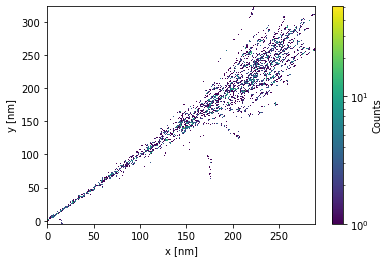

<Figure size 432x288 with 0 Axes>

In [ ]:
generator = np.random.default_rng()

all_xs = []
all_ys = []

for i in range(0,100):
  xs,ys,zs,nVacs = sampleTrack(500,"7Li",rng=generator)
  rot_xs,rot_ys,rot_zs = getRotatedCoords(1,1,0,xs,ys,zs)
  
  #Make a mask of only those entries with nVacss=2
  mask = (np.array(nVacs) == 2)

  all_xs.append(np.array(rot_xs)[mask])
  all_ys.append(np.array(rot_ys)[mask])

#Make into flat arrays
xs_flat = np.concatenate(all_xs)
ys_flat = np.concatenate(all_ys)

#plot
plt.hist2d(xs_flat, ys_flat, bins=250, cmap='viridis', norm=LogNorm())
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.colorbar(label="Counts")
plt.show()
